In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv('flood_data.csv')
data = data.dropna()
X = data.drop('FloodProbability', axis=1)
y = data['FloodProbability']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train = pd.get_dummies(X_train)
X_val = pd.get_dummies(X_val)
X_test = pd.get_dummies(X_test)
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
dnn_model = Sequential()
dnn_model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
dnn_model.add(Dropout(0.3))
dnn_model.add(Dense(32, activation='relu'))
dnn_model.add(Dropout(0.3))
dnn_model.add(Dense(1, activation='linear'))
dnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
dnn_history = dnn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_val_scaled, y_val), callbacks=[early_stop])


In [ ]:
import numpy as np
def mc_dropout_predict(model, data, T=50):
    preds = []
    for i in range(T):
        p = model(data, training=True)
        preds.append(p.numpy())
    preds = np.array(preds)
    mean_pred = preds.mean(axis=0)
    var_pred = preds.var(axis=0)
    return mean_pred, var_pred
dnn_mean_test, dnn_var_test = mc_dropout_predict(dnn_model, X_test_scaled)

In [ ]:
import lightgbm as lgb

gbm_reg = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.1,
    n_estimators=1000
)

gbm_reg.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_val_scaled, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(10), lgb.log_evaluation(100)]
)

preds = gbm_reg.predict(
    X_test_scaled,
    num_iteration=gbm_reg.best_iteration_
)


In [ ]:
from sklearn.utils import resample

gbm_models = []
params = {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.1, 'verbose': -1}
for i in range(5):
    Xb, yb = resample(X_train_scaled, y_train, random_state=i)
    dset = lgb.Dataset(Xb, label=yb)
    m = lgb.train(params, dset, num_boost_round=100)
    gbm_models.append(m)

gbm_preds = []
for m in gbm_models:
    pr = m.predict(X_test_scaled)
    gbm_preds.append(pr)
gbm_preds = np.array(gbm_preds)
gbm_mean_test = gbm_preds.mean(axis=0)
gbm_var_test = gbm_preds.var(axis=0)


In [ ]:
from sklearn.svm import SVR

svr_models = []
for i in range(5):
    Xb, yb = resample(X_train_scaled, y_train, random_state=100+i)
    s = SVR(kernel='rbf')
    s.fit(Xb, yb)
    svr_models.append(s)

svr_preds = []
for s in svr_models:
    p = s.predict(X_test_scaled)
    svr_preds.append(p)
svr_preds = np.array(svr_preds)
svr_mean_test = svr_preds.mean(axis=0)
svr_var_test = svr_preds.var(axis=0)

In [ ]:
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

nb_model = BayesianRidge()
nb_model.fit(X_train_scaled, y_train)
nb_preds = nb_model.predict(X_test_scaled)

dt_model = DecisionTreeRegressor(random_state=1)
dt_model.fit(X_train_scaled, y_train)
dt_preds = dt_model.predict(X_test_scaled)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_preds = lr_model.predict(X_test_scaled)

rf_model = RandomForestRegressor(n_estimators=50, random_state=1)
rf_model.fit(X_train_scaled, y_train)
rf_preds = rf_model.predict(X_test_scaled)

In [3]:
import pickle
import numpy as np
with open("data.pkl", "rb") as f:
    X_train_scaled = pickle.load(f)
    X_val_scaled = pickle.load(f)
    X_test_scaled = pickle.load(f)
    y_train = pickle.load(f)
    y_val = pickle.load(f)
    y_test = pickle.load(f)
with open("ensemblemodelspreds.pkl", "rb") as f:
    dnn_mean_test = pickle.load(f)
    dnn_var_test = pickle.load(f)
    gbm_mean_test = pickle.load(f)
    gbm_var_test = pickle.load(f)
    svr_mean_test = pickle.load(f)
    svr_var_test = pickle.load(f)
with open("modelspreds.pkl", "rb") as f:
    nb_preds = pickle.load(f)
    dt_preds = pickle.load(f)
    lr_preds = pickle.load(f)
    rf_preds = pickle.load(f)

In [4]:
import numpy as np

min_variance = 1e-15  
max_weight = 1e15  

batch_size = 10000

ensemble_mean_test = np.zeros_like(dnn_mean_test)
ensemble_var_test = np.zeros_like(dnn_var_test)
ensemble_mean_test = np.squeeze(ensemble_mean_test)
ensemble_var_test = np.squeeze(ensemble_var_test)

for i in range(0, len(dnn_mean_test), batch_size):
    end = min(i + batch_size, len(dnn_mean_test)) 
    
    dnn_var_batch = dnn_var_test[i:end].reshape(-1)  
    gbm_var_batch = gbm_var_test[i:end].reshape(-1)
    svr_var_batch = svr_var_test[i:end].reshape(-1)

    dnn_mean_batch = dnn_mean_test[i:end].reshape(-1)
    gbm_mean_batch = gbm_mean_test[i:end].reshape(-1)
    svr_mean_batch = svr_mean_test[i:end].reshape(-1)

    safe_dnn_var = np.maximum(dnn_var_batch, min_variance)
    safe_gbm_var = np.maximum(gbm_var_batch, min_variance)
    safe_svr_var = np.maximum(svr_var_batch, min_variance)

    dnn_weight = np.minimum(1 / safe_dnn_var, max_weight).reshape(-1)
    gbm_weight = np.minimum(1 / safe_gbm_var, max_weight).reshape(-1)
    svr_weight = np.minimum(1 / safe_svr_var, max_weight).reshape(-1)

    w_sum = dnn_weight + gbm_weight + svr_weight
    w_dnn = (dnn_weight / w_sum).reshape(-1) 
    w_gbm = (gbm_weight / w_sum).reshape(-1)
    w_svr = (svr_weight / w_sum).reshape(-1)


    ensemble_mean_test[i:end] = (w_dnn * dnn_mean_batch) + (w_gbm * gbm_mean_batch) + (w_svr * svr_mean_batch)
    ensemble_var_test[i:end] = (w_dnn**2 * dnn_var_batch) + (w_gbm**2 * gbm_var_batch) + (w_svr**2 * svr_var_batch)

    print(f"Processed batch {i} - {end}")  


Processed batch 0 - 10000
Processed batch 10000 - 20000
Processed batch 20000 - 30000
Processed batch 30000 - 40000
Processed batch 40000 - 50000
Processed batch 50000 - 60000
Processed batch 60000 - 70000
Processed batch 70000 - 80000
Processed batch 80000 - 90000
Processed batch 90000 - 100000
Processed batch 100000 - 110000
Processed batch 110000 - 120000
Processed batch 120000 - 130000
Processed batch 130000 - 140000
Processed batch 140000 - 150000
Processed batch 150000 - 160000
Processed batch 160000 - 167694


/var/folders/6y/knw7fj0n7cn3c3hykbfpb0mc0000gn/T/ipykernel_91469/3122698483.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["MSE"], palette="coolwarm")


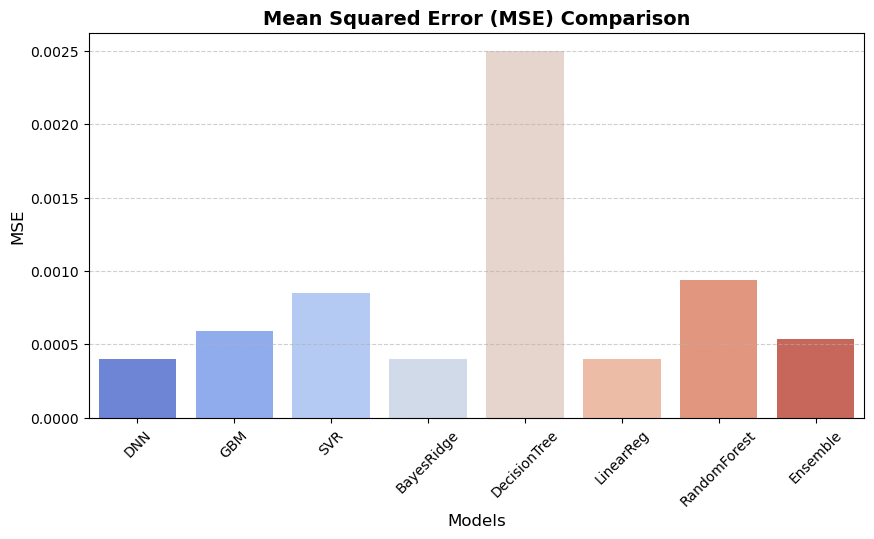

/var/folders/6y/knw7fj0n7cn3c3hykbfpb0mc0000gn/T/ipykernel_91469/3122698483.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["MAE"], palette="viridis")


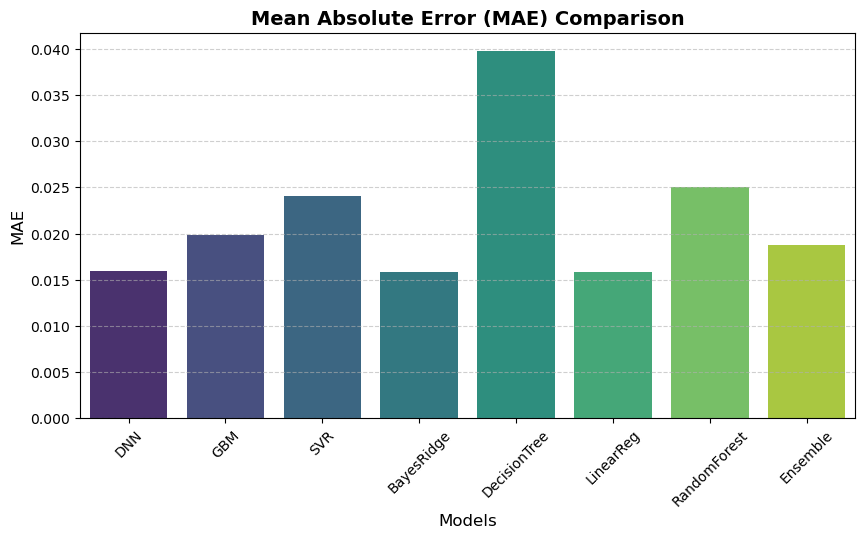

/var/folders/6y/knw7fj0n7cn3c3hykbfpb0mc0000gn/T/ipykernel_91469/3122698483.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["R2 Score"], palette="Blues_r")


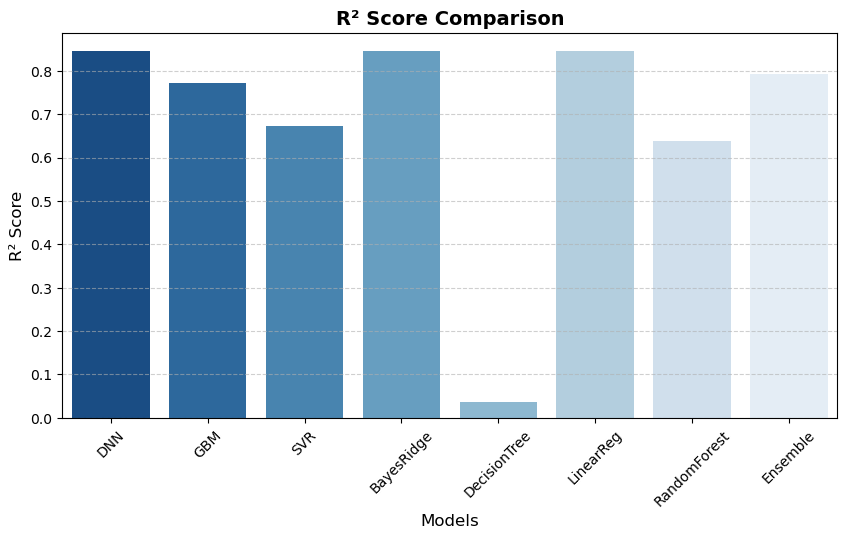

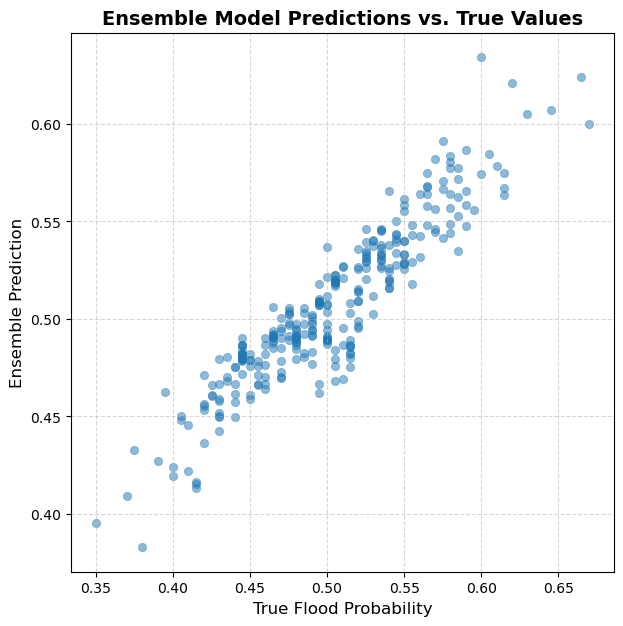

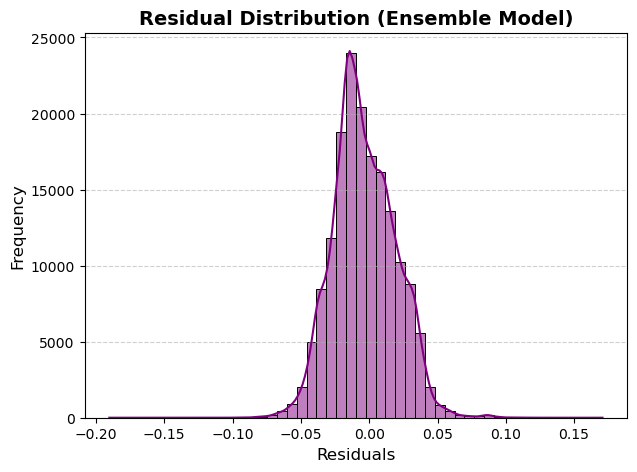

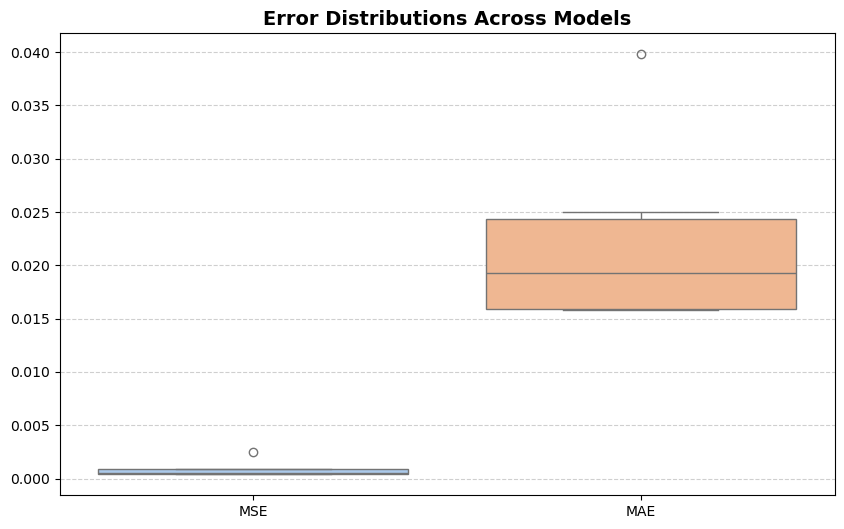

Model Performance Table:
                   MSE       MAE  R2 Score
DNN           0.000402  0.015952  0.845040
GBM           0.000590  0.019872  0.772743
SVR           0.000849  0.024090  0.672831
BayesRidge    0.000404  0.015795  0.844340
DecisionTree  0.002498  0.039785  0.037391
LinearReg     0.000404  0.015795  0.844340
RandomForest  0.000939  0.025033  0.638078
Ensemble      0.000536  0.018770  0.793431


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

models_preds = {
    'DNN': dnn_mean_test,
    'GBM': gbm_mean_test,
    'SVR': svr_mean_test,
    'BayesRidge': nb_preds,
    'DecisionTree': dt_preds,
    'LinearReg': lr_preds,
    'RandomForest': rf_preds,
    'Ensemble': ensemble_mean_test
}

results = {}
for model, pred in models_preds.items():
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    results[model] = (mse, mae, r2)

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE', 'MAE', 'R2 Score'])

plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["MSE"], palette="coolwarm")
plt.title("Mean Squared Error (MSE) Comparison", fontsize=14, fontweight="bold")
plt.xlabel("Models", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["MAE"], palette="viridis")
plt.title("Mean Absolute Error (MAE) Comparison", fontsize=14, fontweight="bold")
plt.xlabel("Models", fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["R2 Score"], palette="Blues_r")
plt.title("R² Score Comparison", fontsize=14, fontweight="bold")
plt.xlabel("Models", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

y_test_np = np.array(y_test)  

idx = np.random.choice(len(y_test_np), size=300, replace=False)

plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test_np[idx], y=np.array(models_preds['Ensemble'])[idx], alpha=0.5, edgecolor=None)
plt.xlabel("True Flood Probability", fontsize=12)
plt.ylabel("Ensemble Prediction", fontsize=12)
plt.title("Ensemble Model Predictions vs. True Values", fontsize=14, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


residuals = y_test - models_preds['Ensemble']
plt.figure(figsize=(7, 5))
sns.histplot(residuals, bins=50, kde=True, color="purple")
plt.title("Residual Distribution (Ensemble Model)", fontsize=14, fontweight="bold")
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=[results_df["MSE"], results_df["MAE"]], palette="pastel")
plt.xticks([0, 1], ["MSE", "MAE"])
plt.title("Error Distributions Across Models", fontsize=14, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

print("Model Performance Table:")
print(results_df)

results_df.to_csv("model_performance.csv", index=True)

In [7]:
print("Keys in models_preds:", models_preds.keys())

Keys in models_preds: dict_keys(['DNN', 'GBM', 'SVR', 'BayesRidge', 'DecisionTree', 'LinearReg', 'RandomForest', 'Ensemble'])


/var/folders/6y/knw7fj0n7cn3c3hykbfpb0mc0000gn/T/ipykernel_91469/1392606962.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["MSE"], palette=mse_palette, ax=axes[0, 0])
/var/folders/6y/knw7fj0n7cn3c3hykbfpb0mc0000gn/T/ipykernel_91469/1392606962.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["MAE"], palette=mae_palette, ax=axes[0, 1])
/var/folders/6y/knw7fj0n7cn3c3hykbfpb0mc0000gn/T/ipykernel_91469/1392606962.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=resu

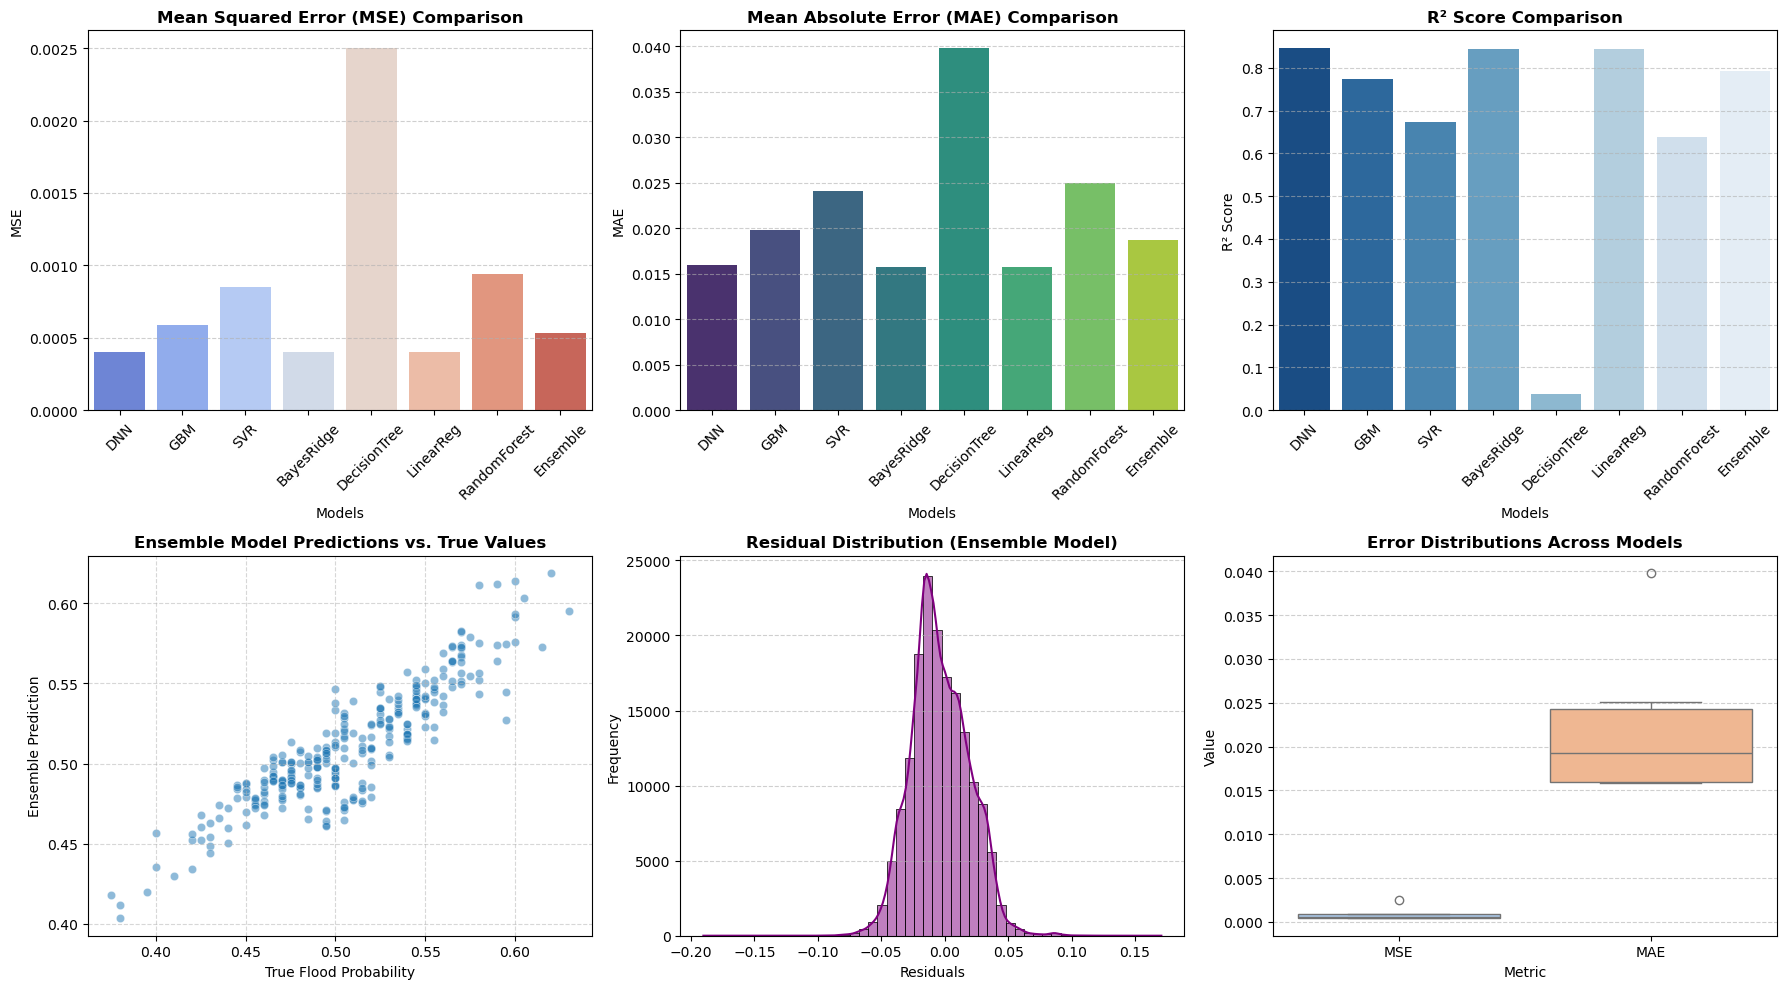

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(18, 10))  

mse_palette = "coolwarm"
mae_palette = "viridis"
r2_palette = "Blues_r"

# MSE Bar Chart
sns.barplot(x=results_df.index, y=results_df["MSE"], palette=mse_palette, ax=axes[0, 0])
axes[0, 0].set_title("Mean Squared Error (MSE) Comparison", fontsize=12, fontweight="bold")
axes[0, 0].set_xlabel("Models", fontsize=10)
axes[0, 0].set_ylabel("MSE", fontsize=10)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis="y", linestyle="--", alpha=0.6)

sns.barplot(x=results_df.index, y=results_df["MAE"], palette=mae_palette, ax=axes[0, 1])
axes[0, 1].set_title("Mean Absolute Error (MAE) Comparison", fontsize=12, fontweight="bold")
axes[0, 1].set_xlabel("Models", fontsize=10)
axes[0, 1].set_ylabel("MAE", fontsize=10)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis="y", linestyle="--", alpha=0.6)

sns.barplot(x=results_df.index, y=results_df["R2 Score"], palette=r2_palette, ax=axes[0, 2])
axes[0, 2].set_title("R² Score Comparison", fontsize=12, fontweight="bold")
axes[0, 2].set_xlabel("Models", fontsize=10)
axes[0, 2].set_ylabel("R² Score", fontsize=10)
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(axis="y", linestyle="--", alpha=0.6)

y_test_np = np.array(y_test)  
ensemble_preds_np = np.array(models_preds['Ensemble'])  

idx = np.random.choice(len(y_test_np), size=300, replace=False)
sns.scatterplot(x=y_test_np[idx], y=ensemble_preds_np[idx], alpha=0.5, ax=axes[1, 0])
axes[1, 0].set_title("Ensemble Model Predictions vs. True Values", fontsize=12, fontweight="bold")
axes[1, 0].set_xlabel("True Flood Probability", fontsize=10)
axes[1, 0].set_ylabel("Ensemble Prediction", fontsize=10)
axes[1, 0].grid(True, linestyle="--", alpha=0.5)

residuals = y_test - models_preds['Ensemble']
sns.histplot(residuals, bins=50, kde=True, color="purple", ax=axes[1, 1])
axes[1, 1].set_title("Residual Distribution (Ensemble Model)", fontsize=12, fontweight="bold")
axes[1, 1].set_xlabel("Residuals", fontsize=10)
axes[1, 1].set_ylabel("Frequency", fontsize=10)
axes[1, 1].grid(axis="y", linestyle="--", alpha=0.6)

error_data = pd.DataFrame({"MSE": results_df["MSE"], "MAE": results_df["MAE"]})
error_data = error_data.melt(var_name="Metric", value_name="Value")
sns.boxplot(x="Metric", y="Value", data=error_data, palette="pastel", ax=axes[1, 2])
axes[1, 2].set_title("Error Distributions Across Models", fontsize=12, fontweight="bold")
axes[1, 2].grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()